# [Keras + Universal Sentence Encoder = Deep Meter](https://www.dlology.com/blog/keras-meets-universal-sentence-encoder-transfer-learning-for-text-data/) 

This notebook creates an autoencoder using the Universal Sentence Encoder. The autoencoder output is CMUdict syllables. The dataset is that subset of Allison Parrish's Project Gutenberg poetry archive which happens to scan in iambic pentameter.

The notebook is based on Chengwei Zhang's example of wrapping the USE inside a larger tensorflow model saves to a Keras model (without save the USE itself in the TF model).

The Universal Sentence Encoder makes getting sentence level embeddings as easy as it has historically been to lookup the embeddings for individual words. The sentence embeddings can then be trivially used to compute sentence level meaning similarity as well as to enable better performance on downstream classification tasks using less supervised training data.

Since there are 10 one-hot values for 10 sets of 6k syllables, this is "multi-label classification"
Changes for multi-label classification:
sigmoid activation instead of softmax
binary_crossentropy

Text format is tab-separated, 2 columns: first text, second multi-level
array of syllables:


# Getting Started

This section sets up the environment for access to the Universal Sentence Encoder on TF Hub and provides examples of applying the encoder to words, sentences, and paragraphs.

In [1]:
# Install the latest Tensorflow version.
!pip3 install --quiet "tensorflow>=1.7"
# Install TF-Hub.
!pip3 install --quiet tensorflow-hub
!pip3 install --quiet pygtrie
%cd /content
!git clone https://github.com/LanceNorskog/deep_meter || true
%cd deep_meter
!git pull
# could not figure out how to read gzipped files as text!
!gunzip -qf blobs/*.gz || true
!gunzip -qf prepped_data/*.gz || true

/content
fatal: destination path 'deep_meter' already exists and is not an empty directory.
/content/deep_meter
remote: Enumerating objects: 10, done.
remote: Counting objects: 100% (10/10), done.
remote: Compressing objects: 100% (4/4), done.
remote: Total 7 (delta 3), reused 7 (delta 3), pack-reused 0
Unpacking objects: 100% (7/7), done.
From https://github.com/LanceNorskog/deep_meter
   8675f56..7700da2  master     -> origin/master
Updating 8675f56..7700da2
Fast-forward
 Deep_Meter_Full.ipynb                      | 1238 ++++++++++++++++++++++++++++
 Deep_Meter_Multi_syllables_interpret.ipynb |  161 ++--
 Deep_Meter_Multi_syllables_model.ipynb     |  767 ++++++++++++++++-
 3 files changed, 2101 insertions(+), 65 deletions(-)
 create mode 100644 Deep_Meter_Full.ipynb
gzip: blobs/*.gz: No such file or directory
gzip: prepped_data/*.gz: No such file or directory


In [2]:
# boilerplate from base notebook
import tensorflow as tf
import tensorflow_hub as hub
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import re
import seaborn as sns
import keras.layers as layers
from keras.models import Model
from keras import backend as K
from keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Nadam, Adam
np.random.seed(10)

Using TensorFlow backend.


In [0]:
# github deep_meter code
import utils
# should not need this to use utils.flatten but is true anyway?
from itertools import chain, product
import subprocess
import syllables
import decodesyllables
import cmudict
# misc for this notebook
from ast import literal_eval

import scipy



In [0]:
module_url = "https://tfhub.dev/google/universal-sentence-encoder-large/3" #@param ["https://tfhub.dev/google/universal-sentence-encoder/2", "https://tfhub.dev/google/universal-sentence-encoder-large/3"]

In [5]:
# Import the Universal Sentence Encoder's TF Hub module
embed = hub.Module(module_url)
embed_size = embed.get_output_info_dict()['default'].get_shape()[1].value

INFO:tensorflow:Using /tmp/tfhub_modules to cache modules.


In [0]:
# read classified poetry lines: text tab [['syll', 'la', 'ble'], ...]
# clip to only most common syllables with syllable manager
def get_data(filename, syll_mgr, num_symbols):
    lines = open(filename, 'r').read().splitlines()
    text_lines = []
    enc_array = []
    num_syllables = syll_mgr.get_size()
    for i in range(0, len(lines)):
      parts = lines[i].split("\t")
      label = utils.flatten(literal_eval(parts[1]))
      if len(label) != num_symbols:
        continue
      enc = np.zeros((num_symbols * syll_mgr.get_size()), dtype=np.int8)
      for j in range(num_symbols):
        enc[num_syllables * j + syll_mgr.get_encoding(label[j])] = 1
      text_lines.append([parts[0]])
      enc_array.append(enc)

    lines = None
    return (np.array(text_lines), np.array(enc_array))


In [0]:
# syllables in descending order of occurrence - 6k in gutenberg.iambic_pentameter, 15k total
# clamp to most common 100 syllables while debugging- use NCE to get all syllables or interesting number
# 98 + pause + wildcard
# iambic pentameter
num_symbols = 10
#syll_mgr = syllables.syllables(num_syllables)
syll_mgr = syllables.syllables()
num_syllables = syll_mgr.get_size() 
syll_weights = {}
counts = syll_mgr.get_counts()
maxim = np.max(counts)
for t in range(10):
  for i in range(len(counts)):
    if counts[i] > 0:
      syll_weights[t * len(counts) + i] = 1/(counts[i]/maxim)
    else:
      syll_weights[t * len(counts) + i] = 0
    

In [8]:
print(syll_weights[15])
(train_text, train_label) = get_data('prepped_data/gutenberg.iambic_pentameter.train', syll_mgr, num_symbols)
num_training = len(train_text)
#train_text = train_text[0:10000]
#train_label = train_label[0:10000]

(test_text, test_label) = get_data('prepped_data/gutenberg.iambic_pentameter.test', syll_mgr, num_symbols)
num_testing = len(test_text)
train_label.shape


11.88058472308009


(58498, 66350)

In [9]:

# slow
num_epochs = 20
adam_lr = 0.001
adam_opt = Adam(lr=adam_lr)
nadam_opt = tf.contrib.opt.NadamOptimizer(adam_lr)
print(type(adam_opt))

<class 'tensorflow.python.keras.optimizers.Adam'>


In [0]:
# weighted binary crossentropy?


## Wrap embed module in a Lambda layer
Explicitly cast the input as a string

In [0]:
def UniversalEmbedding(x):
    return embed(tf.squeeze(tf.cast(x, tf.string)), signature="default", as_dict=True)["default"]


## Assemble model

In [0]:
def create_weighted_binary_crossentropy(zero_weight, one_weight):

    def weighted_binary_crossentropy(y_true, y_pred):

        # Original binary crossentropy (see losses.py):
        # K.mean(K.binary_crossentropy(y_true, y_pred), axis=-1)

        # Calculate the binary crossentropy
        b_ce = K.binary_crossentropy(y_true, y_pred)

        # Apply the weights
        weight_vector = y_true * one_weight + (1. - y_true) * zero_weight
        weighted_b_ce = weight_vector * b_ce

        # Return the mean error
        return K.mean(weighted_b_ce)

    return weighted_binary_crossentropy
  
custom_binary_crossentropy = create_weighted_binary_crossentropy(1/(np.sqrt(num_syllables)), 1 - 1/np.sqrt(num_syllables))

In [0]:
POS_WEIGHT=10
def weighted_binary_crossentropy2(target, output):
    """
    Weighted binary crossentropy between an output tensor 
    and a target tensor. POS_WEIGHT is used as a multiplier 
    for the positive targets.

    Combination of the following functions:
    * keras.losses.binary_crossentropy
    * keras.backend.tensorflow_backend.binary_crossentropy
    * tf.nn.weighted_cross_entropy_with_logits
    """
    # transform back to logits
    _epsilon = tfb._to_tensor(tfb.epsilon(), output.dtype.base_dtype)
    output = tf.clip_by_value(output, _epsilon, 1 - _epsilon)
    output = tf.log(output / (1 - output))
    # compute weighted loss
    loss = tf.nn.weighted_cross_entropy_with_logits(targets=target,
                                                    logits=output,
                                                    pos_weight=POS_WEIGHT)
    return tf.reduce_mean(loss, axis=-1)


In [0]:
def hamming_loss(y_true, y_pred):
  return K.mean(y_true*(1-y_pred)+(1-y_true)*y_pred)

In [14]:
output_activation='sigmoid'
# changed accuracy from 'choose your own accuracy'
input_text = layers.Input(shape=(1,), dtype=tf.string)
embedding = layers.Lambda(UniversalEmbedding, output_shape=(embed_size,), name='TF-Hub')(input_text)
embedding = layers.Dropout(0.5)(embedding)
dense = layers.Dense(1024, activation='relu', name='Convoluted')(embedding)
dense = layers.Dropout(0.5)(dense)
dense = layers.Dense(2048, activation='relu', name='Medium')(dense)
dense = layers.Dropout(0.5)(dense)
dense = layers.Dense(4096, activation='relu', name='Smooth')(dense)
dense = layers.Dropout(0.5)(dense)
pred = layers.Dense(num_symbols * num_syllables, activation=output_activation, name='Flatout')(dense)
model = Model(inputs=[input_text], outputs=pred)
model.compile(loss=custom_binary_crossentropy, 
              optimizer=nadam_opt, 
              metrics=['binary_crossentropy']
             )
model.summary()

INFO:tensorflow:Saver not created because there are no variables in the graph to restore
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 1)                 0         
_________________________________________________________________
TF-Hub (Lambda)              (None, 512)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
Convoluted (Dense)           (None, 1024)              525312    
_________________________________________________________________
dropout_2 (Dropout)          (None, 1024)              0         
_________________________________________________________________
Medium (Dense)               (None, 2048)              2099200   
_____________________________________________________

## Train Keras model and save weights
This only trains and save our Keras layers not the embed module' weights.

In [15]:
history = None
use_saved_model=True
if not use_saved_model or not os.path.exists('./model.h5'):
  with tf.Session() as session:
    K.set_session(session)
    session.run(tf.global_variables_initializer())
    session.run(tf.tables_initializer())
    history = model.fit(train_text, 
            train_label,
            validation_data=(test_text, test_label),
            epochs=num_epochs,
            #callbacks = [EarlyStopping(patience=5)],
            batch_size=32,
            verbose=2
            ,class_weight=syll_weights
    )
    model.save_weights('./model.h5')


Train on 58498 samples, validate on 4200 samples
Epoch 1/20
 - 408s - loss: 0.0098 - binary_crossentropy: 0.0117 - val_loss: 4.5444e-04 - val_binary_crossentropy: 0.0058
Epoch 2/20
 - 397s - loss: 0.0088 - binary_crossentropy: 0.0094 - val_loss: 4.1694e-04 - val_binary_crossentropy: 0.0107
Epoch 3/20
 - 398s - loss: 0.0086 - binary_crossentropy: 0.0093 - val_loss: 4.0814e-04 - val_binary_crossentropy: 0.0099
Epoch 4/20
 - 397s - loss: 0.0085 - binary_crossentropy: 0.0092 - val_loss: 3.9940e-04 - val_binary_crossentropy: 0.0098
Epoch 5/20
 - 398s - loss: 0.0085 - binary_crossentropy: 0.0092 - val_loss: 4.0132e-04 - val_binary_crossentropy: 0.0092
Epoch 6/20
 - 397s - loss: 0.0084 - binary_crossentropy: 0.0092 - val_loss: 3.9772e-04 - val_binary_crossentropy: 0.0091
Epoch 7/20
 - 395s - loss: 0.0084 - binary_crossentropy: 0.0093 - val_loss: 3.9759e-04 - val_binary_crossentropy: 0.0095
Epoch 8/20
 - 395s - loss: 0.0084 - binary_crossentropy: 0.0092 - val_loss: 3.9750e-04 - val_binary_cros

In [16]:
!ls -alh | grep model.h5

-rw-r--r-- 1 root root 1.1G Nov 10 05:24 model.h5


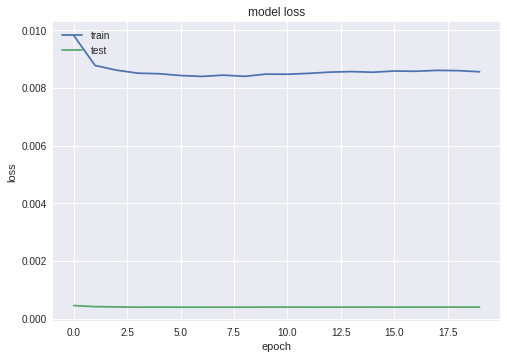

In [17]:
if history != None:
  # summarize history for accuracy
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
  plt.show()

val_loss
val_binary_crossentropy
loss
binary_crossentropy


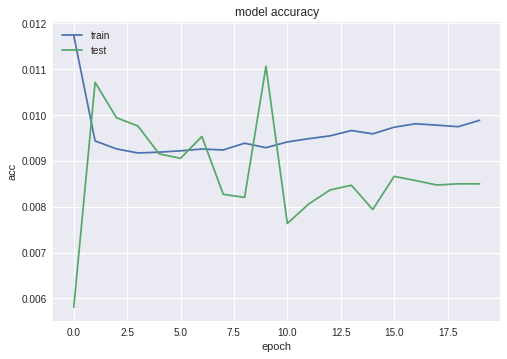

In [20]:
for key in history.history.keys():
    print(key)
if history != None:
  # summarize history for accuracy
  plt.plot(history.history['binary_crossentropy'])
  plt.plot(history.history['val_binary_crossentropy'])
  plt.title('model accuracy')
  plt.ylabel('acc')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
  plt.show()

## Make predictions

In [0]:

#new_text = np.array(new_text, dtype=object)[:, np.newaxis]
with tf.Session() as session:
  K.set_session(session)
  session.run(tf.global_variables_initializer())
  session.run(tf.tables_initializer())
  #model.load_weights('./model.h5')  
  predicts = model.predict(test_text, batch_size=32)

In [0]:
decoder = decodesyllables.Decoder(cmudict.CMUDict())

In [0]:
num_tests = min(10, len(test_text))
max_variants = 4
min_factor = 0.1
# Collect possible syllables from each output model
# [num_lines][num_symbols][N > 0.8]
index_arrays = [[]] * num_tests
for j in range(num_tests):
    index_arrays[j] = [[]] * num_symbols
    for i in range(num_symbols):
      index_arrays[j][i] = []
      
# index into each possible syllable and score
for i in range(num_symbols):
  for j in range(num_tests):
    for k in range(num_syllables):
      if predicts[j][i * num_syllables + k] > min_factor:
        #print("i, j {0},{1}, -> {2}".format(i,j,k))
        index_arrays[j][i].append(k)
        
# sort order of possible syllables at each slot by score
for j in range(num_tests):
  indexes = index_arrays[j]
  for i in range(num_symbols):
    score_set = [1.0] * len(indexes[i])
    for k in range(len(indexes[i])):
      score_set[k] = predicts[j][i * num_syllables + k]
    new_indexes = []
    sorted_i = list(np.argsort(score_set))
    sorted_i.reverse()
    for x in sorted_i:
      new_indexes.append(indexes[i][x])
    index_arrays[j][i] = new_indexes[0:max_variants]
#for j in range(min(num_tests,30)):
#  print(index_arrays[j])

In [39]:

for j in range(0,num_tests):
  print("Predicting sentence: " + str(test_text[j]))
  n = 0
  score_list = []
  syll_list = []
  for index_list in product(*index_arrays[j]):
    score_sum = 0.0
    for i in range(num_symbols):
      score_sum += predicts[j][i * num_syllables + index_list[i]]
    score_list.append(score_sum)
    syll_set = [''] * num_symbols
    for i in range(num_symbols):
      syll_set[i] = syll_mgr.get_syllable(index_list[i])
    syll_list.append(syll_set)
  if len(score_list) == 0:
    print("  no syllable sets found")
    continue
  #print(score_list)
  topindexes = list(np.argsort(score_list))
  topindexes.reverse()
  #print(topindexes)
  for index in topindexes[0:5]:
    # print("Score: {0}".format(score_list[index]))
    count = 0
    for s in decoder.decode_sentence(syll_list[index]):
      print(s)
      count += 1
      if count == 4:
        break
 

Predicting sentence: ['To life, the creamy onyx and the skins']
Predicting sentence: ['And what is Man the while? And what his will?']
Predicting sentence: ['Of startled grasses, and the hedge in bloom,--']
couch taints whilst scarf pose vorce bows shan gretz munn
Predicting sentence: ['The match was offered, the proposals made']
Predicting sentence: ['Were landed in the market, one and all,']
Predicting sentence: ['The vale of Nature, where it creeps and winds']
Predicting sentence: ['And Bacchus city had become enthralled,']
Predicting sentence: ['The marks of seasons wild and winters bleak']
Predicting sentence: ['That in the sunshine floats, beneath the blue,']
smacked coasts(3) chriss slant joist of(2) bows frosts tough munn
smacked coasts(3) chriss reels joist of(2) bows frosts tough munn
smacked coasts(3) chriss slant joist utz bows frosts tough munn
smacked coasts(3) chriss reels joist utz bows frosts tough munn
Predicting sentence: ['His burning idol all of blackest hue:']
alf

In [20]:
for i in range(10,100):
  print(test_text[i])
  syll_mgr.interpret2(predicts[i])
  print('')
  
print(predicts[0])

['Of humble seeming: and, behind them all,']
[5371, 2572, 4997, 3871, 5275, 2572, 1263, 1690, 5364, 74]
['L AH NG', 'DH EH R Z', 'JH IH R', 'S T AA R V', 'SH R AH NG', 'DH EH R Z', 'B AW Z', 'W OW N T', 'N EY T', 'M AH N']

['Behind his head upon the shoulders lay,']
[6489, 3001, 3927, 6355, 369, 2957, 2028, 1718, 5209, 74]
['S M AE K T', 'F AE L S', 'AE N T', 'S L AE N T', 'TH IH NG Z', 'P R IH N T S', 'F L IH', 'HH OW S T S', 'HH IH P', 'M AH N']

['Discover countries, with a kindred heart']
[1018, 2582, 3368, 2935, 1637, 5840, 6451, 2489, 486, 1039]
['R AO NG', 'S W IY T S', 'K IH N Z', 'S T IH L D', 'V IH R', 'T AA M P', 'B L OW K', 'JH EH M Z', 'B R EH TH', 'SH EY P']

['Was open in his praise, and plaudits rose']
[4731, 4217, 2826, 4907, 4738, 6430, 1263, 4355, 3359, 74]
['N AE L Z', 'V OW L', 'T AH F', 'HH AA G Z', 'T AO R Z', 'HH OW V', 'B AW Z', 'K AA N Z', 'G R EH T S', 'M AH N']

['A spear the hero bore of wondrous strength,']
[4731, 2923, 843, 2781, 1209, 5469, 1263, 880, 3

In [19]:
categories = df_train.label.cat.categories.tolist()
predict_logits = predicts.argmax(axis=1)
print("Categorie: {0}".format(categories))
predict_labels = [categories[logit] for logit in predict_logits]
predict_labels

NameError: ignored

In [0]:

os.remove('./model.h5')